# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import QuantileTransformer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import AdaBoostClassifier, StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV


from sklearn.model_selection import cross_validate, cross_val_score

### Data Import

In [3]:
train_data = "/kaggle/input/e-commerce-shoppers-behaviour-understanding/train_data_v2.csv"
df=pd.read_csv(train_data)
df.head(5)

,HomePage,HomePage_Duration,LandingPage,LandingPage_Duration,ProductDescriptionPage,ProductDescriptionPage_Duration,GoogleMetric:Bounce Rates,GoogleMetric:Exit Rates,GoogleMetric:Page Values,SeasonalPurchase,...,SearchEngine,Zone,Type of Traffic,CustomerType,Gender,Cookies Setting,Education,Marital Status,WeekendPurchase,Made_Purchase
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,1.0,9.0,3.0,Returning_Visitor,Not Specified,Deny,Not Specified,Other,0.0,False
1,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,...,2.0,2.0,4.0,Returning_Visitor,Female,Deny,Others,Married,0.0,False
2,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,...,3.0,1.0,4.0,Returning_Visitor,Female,ALL,Others,Married,1.0,False
3,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.4,...,4.0,3.0,3.0,Returning_Visitor,Male,ALL,Diploma,Single,0.0,False
4,1.0,0.0,0.0,0.0,0.0,0.000000,0.20,0.20,0.0,0.0,...,2.0,1.0,5.0,Returning_Visitor,Male,Deny,Diploma,Other,1.0,False


# Looking Into The Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14731 entries, 0 to 14730
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HomePage                         14578 non-null  float64
 1   HomePage_Duration                14581 non-null  float64
 2   LandingPage                      14578 non-null  float64
 3   LandingPage_Duration             14596 non-null  float64
 4   ProductDescriptionPage           14608 non-null  float64
 5   ProductDescriptionPage_Duration  14564 non-null  float64
 6   GoogleMetric:Bounce Rates        14580 non-null  float64
 7   GoogleMetric:Exit Rates          14602 non-null  float64
 8   GoogleMetric:Page Values         14599 non-null  float64
 9   SeasonalPurchase                 14581 non-null  float64
 10  Month_SeasonalPurchase           14587 non-null  object 
 11  OS                               14597 non-null  float64
 12  SearchEngine      

In [5]:
df.isnull().sum()

HomePage                           153
HomePage_Duration                  150
LandingPage                        153
LandingPage_Duration               135
ProductDescriptionPage             123
ProductDescriptionPage_Duration    167
GoogleMetric:Bounce Rates          151
GoogleMetric:Exit Rates            129
GoogleMetric:Page Values           132
SeasonalPurchase                   150
Month_SeasonalPurchase             144
OS                                 134
SearchEngine                       122
Zone                               117
Type of Traffic                    143
CustomerType                       144
Gender                             145
Cookies Setting                    144
Education                          136
Marital Status                     130
WeekendPurchase                    121
Made_Purchase                        0
dtype: int64

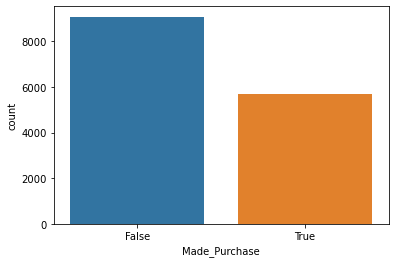

In [6]:
sns.countplot(data=df, x='Made_Purchase');
# data imbalanced

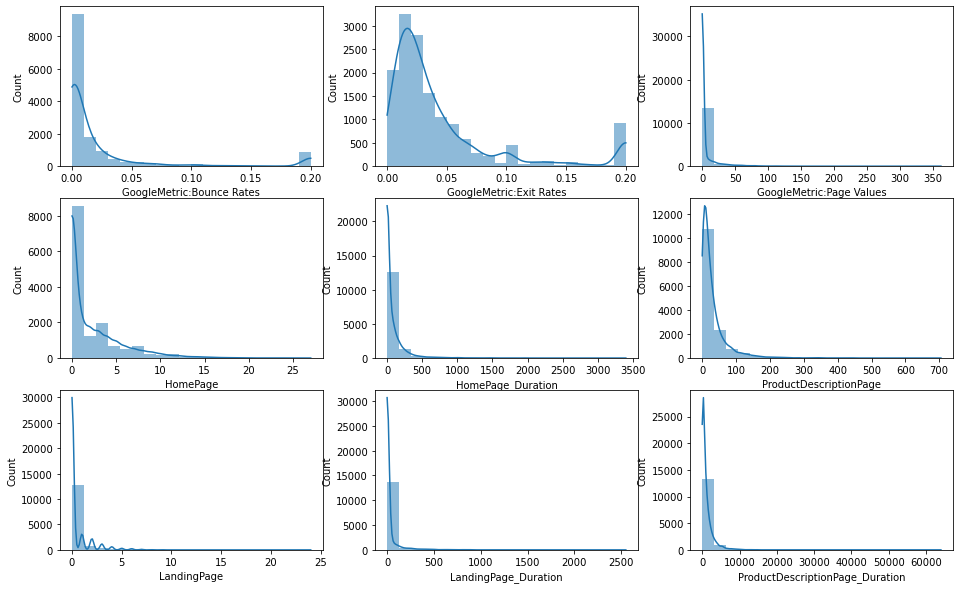

In [7]:
fig = plt.figure(figsize=(16, 10))
ax = []
for i in range(1, 10):
    ax.append(fig.add_subplot(3, 3, i))

sns.histplot(df['GoogleMetric:Bounce Rates'], bins=20, ax=ax[0], kde=True, linewidth=0)
sns.histplot(df['GoogleMetric:Exit Rates'], bins=20, ax=ax[1], kde=True, linewidth=0)
sns.histplot(df['GoogleMetric:Page Values'], bins=20, ax=ax[2], kde=True, linewidth=0)
    
sns.histplot(data=df, x = 'HomePage', bins=20, ax=ax[3], kde=True, linewidth=0)
sns.histplot(data=df, x = 'HomePage_Duration', bins=20, ax=ax[4], kde=True, linewidth=0)
sns.histplot(data=df, x = 'ProductDescriptionPage', bins=20, ax=ax[5], kde=True, linewidth=0)
    
sns.histplot(data=df, x = 'LandingPage', bins=20, ax=ax[6], kde=True, linewidth=0)
sns.histplot(data=df, x = 'LandingPage_Duration', bins=20, ax=ax[7], kde=True, linewidth=0)
sns.histplot(data=df, x = 'ProductDescriptionPage_Duration', bins=20, ax=ax[8], kde=True, linewidth=0)

plt.show()

# skewed data - need to transform to normal or uniform distribution 

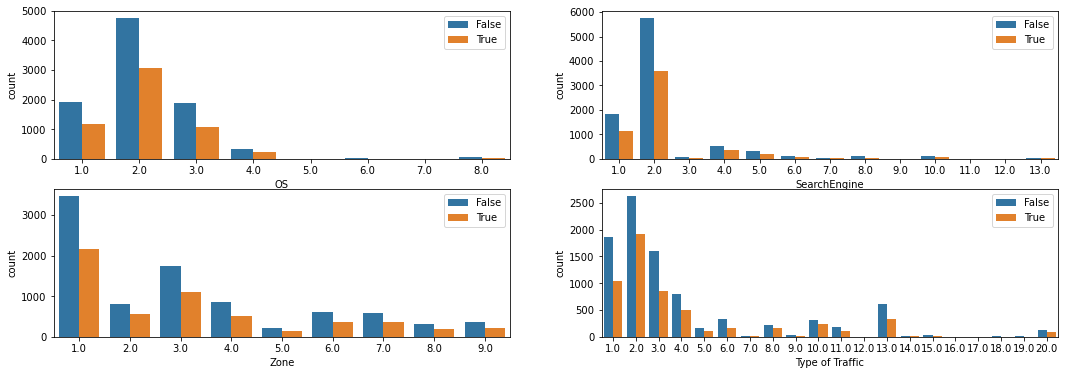

In [8]:
fig = plt.figure(figsize=(18, 6))
ax = []
for i in range(1, 5):
    ax.append(fig.add_subplot(2, 2, i))

sns.countplot(data=df, x='OS', hue='Made_Purchase', ax=ax[0])
sns.countplot(data=df, x='SearchEngine', hue='Made_Purchase', ax=ax[1])
sns.countplot(data=df, x='Zone', hue='Made_Purchase', ax=ax[2])
sns.countplot(data=df, x='Type of Traffic', hue='Made_Purchase', ax=ax[3])

for i in range(len(ax)):
    ax[i].legend(loc='upper right')
plt.show()

# not much difference based on these things - showing dataimbalnce

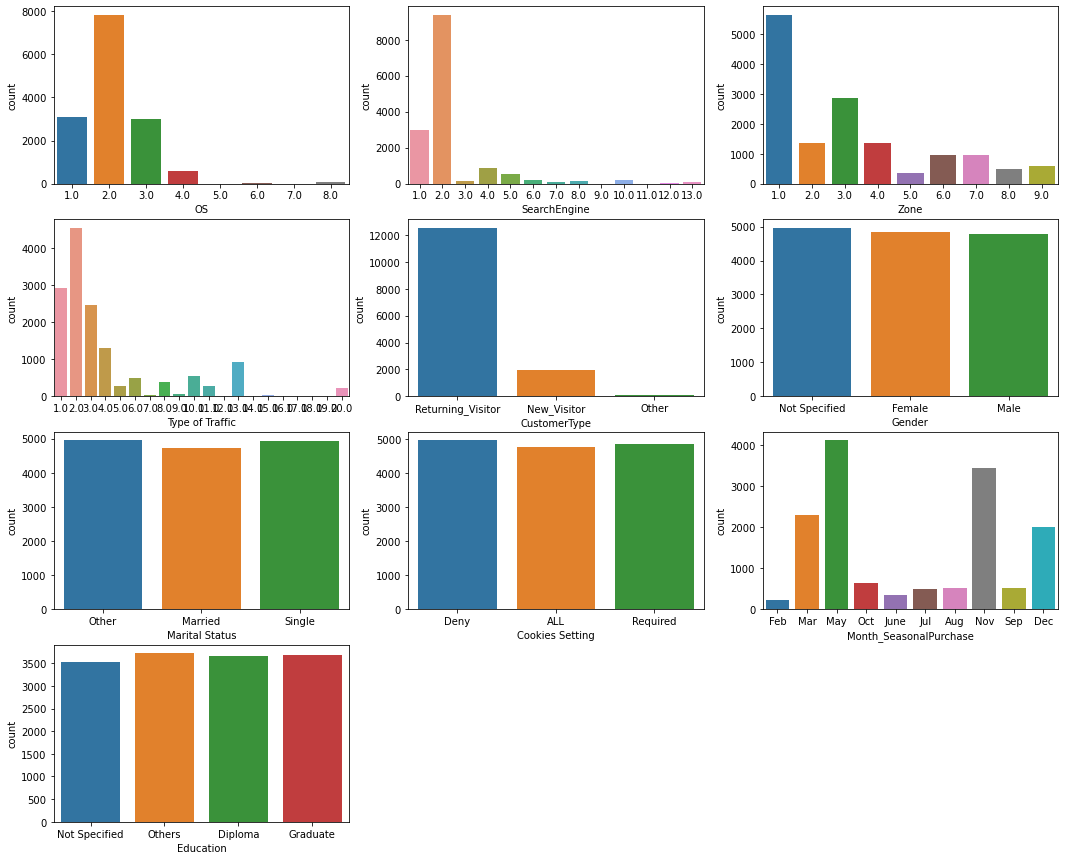

In [9]:
fig = plt.figure(figsize=(18, 15))

ax = []
for i in range(1, 11):
    ax.append(fig.add_subplot(4, 3, i))

sns.countplot(data=df, x='OS', ax=ax[0])
sns.countplot(data=df, x='SearchEngine', ax=ax[1])
sns.countplot(data=df, x='Zone', ax=ax[2])
sns.countplot(data=df, x='Type of Traffic', ax=ax[3])
sns.countplot(data=df, x='CustomerType', ax=ax[4])
sns.countplot(data=df, x='Gender', ax=ax[5])
sns.countplot(data=df, x='Marital Status', ax=ax[6])
sns.countplot(data=df, x='Cookies Setting', ax=ax[7])
sns.countplot(data=df, x='Month_SeasonalPurchase', ax=ax[8])
sns.countplot(data=df, x='Education', ax=ax[9])
plt.show()

# cookie setting, marital status gender and education have all equal number of data points in the data set

# Split The Data

In [10]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=41)

for train_index, test_index in sss.split(df, df['Made_Purchase']):
    train, test = df.loc[train_index], df.loc[test_index]

### train test (validation) split

In [11]:
X = train.drop('Made_Purchase', axis = 1).reset_index().drop('index', axis=1)
y = train['Made_Purchase'].reset_index().drop('index', axis=1)
X_test = test.drop('Made_Purchase', axis = 1).reset_index().drop('index', axis=1)
y_test = test['Made_Purchase'].reset_index().drop('index', axis=1)

### Splitting Variable Set - Categorical / numerical 

In [12]:
numericVar = ['HomePage', 'HomePage_Duration', 'LandingPage', 'LandingPage_Duration',
       'ProductDescriptionPage', 'ProductDescriptionPage_Duration',
       'GoogleMetric:Bounce Rates', 'GoogleMetric:Exit Rates',
       'GoogleMetric:Page Values', 'SeasonalPurchase',
       'OS', 'SearchEngine', 'Zone','Type of Traffic', 'WeekendPurchase']
one_hot_cats =['Month_SeasonalPurchase', 'CustomerType', 
               'Gender', 'Cookies Setting',
               'Education', 'Marital Status']

# Preprocessing Function and Pipelines

In [13]:
def myPreprocessing(df):   
    '''
    putting Nan on improper values
    Input - dataframe - incorrect values
    Output - dataframe - nan replaced on improper values
    '''
    df.loc[(df.HomePage == 0) & (df.HomePage_Duration > 0), 'HomePage'] = np.nan
    df.loc[(df.HomePage > 0) & (df.HomePage_Duration == 0), 'HomePage_Duration'] = np.nan
    df.loc[(df.LandingPage == 0) & (df.LandingPage_Duration > 0), 'LandingPage'] = np.nan
    df.loc[(df.LandingPage > 0) & (df.LandingPage_Duration == 0), 'LandingPage_Duration'] = np.nan
    df.loc[(df.ProductDescriptionPage == 0) & (df.ProductDescriptionPage_Duration > 0), 'ProductDescriptionPage'] = np.nan
    df.loc[(df.ProductDescriptionPage > 0) & (df.ProductDescriptionPage_Duration == 0), 'ProductDescriptionPage_Duration'] = np.nan
    df.loc[(df.SeasonalPurchase > 0) & (df.Month_SeasonalPurchase.isnull()), 'Month_SeasonalPurchase'] = np.nan
    return df

In [14]:

encoder = ColumnTransformer(
    transformers=[
                  ('ord_encode', 
                   OneHotEncoder(handle_unknown='ignore'), 
                   one_hot_cats),
                 ],remainder='passthrough')

impute = Pipeline(
    steps=[('encoder', encoder),
           ('imputer', IterativeImputer(random_state=0)),
           ('scaler', StandardScaler()),
           ('normaliser', QuantileTransformer(n_quantiles=100, output_distribution='normal'))
          ])

## Fitting the pipelines - converting it back to Dataframe to peek

In [15]:
X = myPreprocessing(X)
X = impute.fit_transform(X, y)
X_test = impute.transform(X_test)

columns = list(encoder.transformers_[0][1].get_feature_names_out()) + numericVar
X = pd.DataFrame(X, columns = columns)
X_test = pd.DataFrame(X_test, columns = columns)

# Removing Outliers From Training Set
There are abnormal values - like abnormal amount of time in pages duration removing them is essential 

In [16]:
outlier = IsolationForest(n_estimators=1000, contamination = 'auto', random_state=0)
L = outlier.fit_predict(X)

unique, counts = np.unique(L, return_counts=True)
unique, counts

(array([-1,  1]), array([ 1362, 11895]))

In [17]:
X['Outlier'] = L
X['label'] = y

X_New = X.loc[X.Outlier == 1].reset_index().drop(['Outlier', 'index', 'label'], axis=1)
y_New = X.loc[X.Outlier == 1].reset_index()['label']

In [18]:
X_New.describe().T

,count,mean,std,min,25%,50%,75%,max
Month_SeasonalPurchase_Aug,11895.0,-4.888995,1.769493,-5.199338,-5.199338,-5.199338,-5.199338,5.199338
Month_SeasonalPurchase_Dec,11895.0,-3.833828,3.512251,-5.199338,-5.199338,-5.199338,-5.199338,5.199338
Month_SeasonalPurchase_Feb,11895.0,-5.040232,1.276443,-5.199338,-5.199338,-5.199338,-5.199338,5.199338
Month_SeasonalPurchase_Jul,11895.0,-4.880253,1.793465,-5.199338,-5.199338,-5.199338,-5.199338,5.199338
Month_SeasonalPurchase_June,11895.0,-4.977289,1.503294,-5.199338,-5.199338,-5.199338,-5.199338,5.199338
Month_SeasonalPurchase_Mar,11895.0,-3.506001,3.839571,-5.199338,-5.199338,-5.199338,-5.199338,5.199338
Month_SeasonalPurchase_May,11895.0,-2.135247,4.740857,-5.199338,-5.199338,-5.199338,5.199338,5.199338
Month_SeasonalPurchase_Nov,11895.0,-2.709600,4.437661,-5.199338,-5.199338,-5.199338,-5.199338,5.199338
Month_SeasonalPurchase_Oct,11895.0,-4.841788,1.894863,-5.199338,-5.199338,-5.199338,-5.199338,5.199338
Month_SeasonalPurchase_Sep,11895.0,-4.876756,1.802953,-5.199338,-5.199338,-5.199338,-5.199338,5.199338


# Balancing The Dataset - SMOTE

In [19]:
rus = SMOTE(random_state=0)

X, y = rus.fit_resample(X_New, y_New)
print(y.value_counts(), y_New.value_counts(), sep = '\n')

True     7448
False    7448
Name: label, dtype: int64
False    7448
True     4447
Name: label, dtype: int64


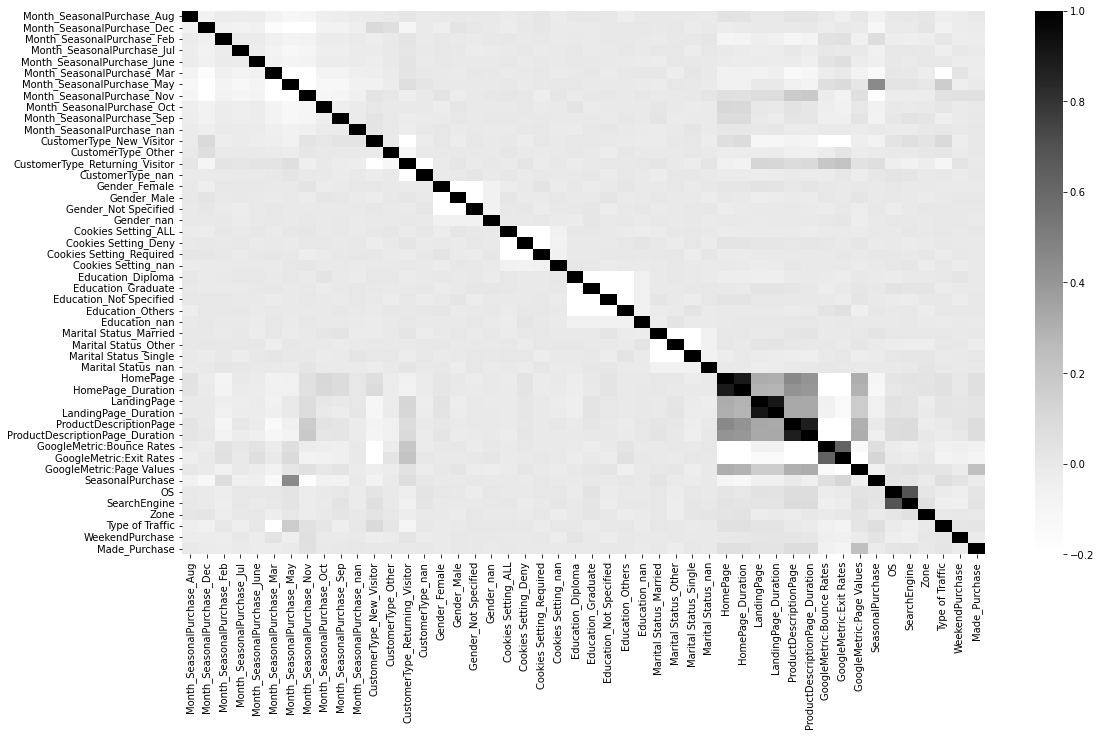

In [20]:
dataCopy = X.copy()
dataCopy['Made_Purchase'] = y.values
plt.figure(figsize = (18, 10))
sns.heatmap(dataCopy.corr(), annot=False,cmap='Greys', vmin=-0.2, vmax=1);

In [21]:
# clf = SVC(C=10)
# 0.646

# clf1= DecisionTreeClassifier(min_samples_split = 10,min_impurity_decrease=0.01, max_depth=3)
# 0.6732

# estimators = [
#     ('adaboost', AdaBoostClassifier(clf1, n_estimators=100, learning_rate=0.1)),
#    ('rf', RandomForestClassifier(n_estimators=50, random_state=42))
#  ]
# clf = StackingClassifier(estimators=estimators,  passthrough=True, cv=10,
#                        final_estimator = XGBClassifier(n_estimators=100, learning_rate=0.01, random_state=42))
# 0.7461825585341024

estimators = [
    ('adaboost', AdaBoostClassifier(n_estimators=100, learning_rate=0.1)),
    ('rf', RandomForestClassifier(n_estimators=40, random_state=0))
 ]

clf = StackingClassifier(estimators=estimators, passthrough=True,
                         final_estimator = XGBClassifier(n_estimators=150, learning_rate=0.01, random_state=0))
# 0.7523744911804613

clf.fit(X, y)

y_hat = clf.predict(X_test)
score1 = clf.score(X_test, y_test)
print(score1)

0.7564450474898237


Cross validate the classifier on train set

In [22]:
score = cross_val_score(clf, X, y, scoring='f1_micro', cv=10)
print('Score: ', score.mean() )

Score:  0.7433066649839314


In [23]:
cr = classification_report(y_test, y_hat)
print('Classification Report - Test Set \n\n', cr)

Classification Report - Test Set 

               precision    recall  f1-score   support

       False       0.78      0.84      0.81       907
        True       0.71      0.62      0.66       567

    accuracy                           0.76      1474
   macro avg       0.74      0.73      0.74      1474
weighted avg       0.75      0.76      0.75      1474



## Hyperparameter Tuning
hyper parameter tuning of this classifier takes more than 20/30 mins. Tuned classifier has been used above as final, and the tuning part is commented on .

In [24]:
# hyper parameter tuning
n_estimator = [5, 10, 20, 30, 40, 50, 70, 100, 150, 200, 250, 500]
learning_rate = [0.1, 0.01, 0.001, 1, 10]
param = {
    'rf__n_estimators': n_estimator,
    'adaboost__n_estimators':n_estimator,
    'final_estimator__n_estimator': n_estimator,
    'adaboost__learning_rate':learning_rate, 
    'final_estimator__learning_rate':learning_rate,
}

tuned_clf = RandomizedSearchCV(clf,
                            param_distributions= param,
                            cv=10,
                            scoring='f1_micro',
                            n_iter=10,
                            n_jobs=-1,
                            error_score = 'raise',
                            refit=True, 
                            random_state = 42)
# tuned_clf.fit(X, y)
# y_hat_tuned = tuned_clf.predict(X_test)
# score2 = tuned_clf.score(X_test, y_test)
# print(score2)
# print(tuned_clf.best_estimator_)
# tuned = tuned_clf.best_estimator_

# Predicting Finally on Test Data

In [25]:
test_data = "/kaggle/input/e-commerce-shoppers-behaviour-understanding/test_data_v2.csv"
test_df = pd.read_csv(test_data)
test_df = myPreprocessing(test_df)
test_df = pd.DataFrame(impute.transform(test_df), columns = columns)
y_pred = clf.predict(test_df)

output = pd.DataFrame(y_pred.astype(bool))
output = output.reset_index()
output = output.rename(columns = {'index':'id',0:'Made_Purchase'})
output.Made_Purchase.value_counts()

False    4374
True     2225
Name: Made_Purchase, dtype: int64

## Submission File

In [26]:
output.to_csv('submission.csv',index = False)